# Анализ и подготовка плана действий по удержанию клиентов сети фитнес-центров

## Оглавление
<a id = "index"></a>

1. [Задание](#task)
1. [Описание данных](#data_description)
1. [Настройка окружения](#env)
1. [Загрузка данных](#upload)

1. [Подготовка данных](#etl)
1. [Анализ данных](#eda)

1. [Прогноз оттока пользователей](#churn_forecast)
1. [Кластеризация пользователей](#clustering)
1. [Выводы и рекомендации](#conclusion)

## Задание
<a id = "task"></a>
[В оглавление](#index)

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных. Отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество анкет пользователей. Необходимо провести анализ и подготовить план действий по удержанию клиентов:  
- спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:  
1) выделить целевые группы клиентов;  
2) предложить меры по снижению оттока;  
3) определить другие особенности взаимодействия с клиентами.  

## Описание данных
<a id = "data_description"></a>
[В оглавление](#index)

Датафрейм __gym_churn__:
- `gender` — пол
- `Near_Location` — проживание или работа в районе расположения фитнес-центра
- `Partner` — сотрудник компании-партнёра клуба со скидкой на абонемент
- `Promo_friends` — использование промо-кода от знакомого при оплате первого абонемента (акция «приведи друга»)
- `Phone` — указание контактного телефона
- `Contract_period` — длительность действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- `Group_visits` — факт посещения групповых занятий
- `Age` — возраст
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра (кафе, спорт-товары, косметический и массажный салон)
- `Month_to_end_contract` — срок до окончания действующего абонемента (в месяцах)
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах)
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц
- `Churn` — факт оттока в текущем месяце

___

- Данные пользователя за предыдущий до проверки факта оттока месяц
- Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента

## Настройка окружения
<a id = "env"></a>
[В оглавление](#index)

In [1]:
pip install --upgrade pandas

Requirement already up-to-date: pandas in /Users/maksim/opt/anaconda3/lib/python3.7/site-packages (1.1.3)
You should consider upgrading via the '/Users/maksim/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# библиотеки прогнозирования
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# библиотеки кластеризации
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# шрифт заголовков
title_font = {
    'size':'20', 
    'color':'black', 
    'weight':'bold',
    'verticalalignment':'bottom'
}

# отображение знаков после запятой
pd.options.display.float_format = '{:,.2f}'.format

# отключение предупреждений Anaconda
import warnings
warnings.simplefilter('ignore')

## Загрузка и первичное изучение данных
<a id = "upload"></a>
[В оглавление](#index)

In [3]:
try:
    gym = pd.read_csv('gym_churn.csv', sep=',')
except:
    gym = pd.read_csv('/datasets/gym_churn.csv', sep=',')

In [4]:
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [5]:
gym.head(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


In [6]:
# проверка наличия дубликатов записей
gym.duplicated().sum()

0

### Вывод по разделу

- В датафрейме нет пропусков.
- В датафрейме нет дубликатов записей.
- Названия колонок необходимо привести в строчный вид.
- Требуется перевод столбца `Month_to_end_contract` в целочисленный вид.

## Подготовка данных
<a id = "etl"></a>
[В оглавление](#index)

In [7]:
# перевод названия колонок в строчный вид
gym.columns = gym.columns.str.lower()

In [8]:
# перевод столбца month_to_end_contract в целочисленный вид
gym['month_to_end_contract'] = gym['month_to_end_contract'].astype('int')

In [9]:
gym.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.23,5,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1,3,1.11,1.12,0


- Названия колонок переведены в строчный вид.
- Столбец `Month_to_end_contract` переведен в целочисленный вид.
- __Датафрейм готов к дальнейшему анализу.__

In [10]:
# словарь названий столбцов на русском для эстетичной визуализации
column_dict = {
    'gender': 'Пол',
    'near_location': 'Близкое расположение зала',
    'partner': 'Скидка партнера',
    'promo_friends': 'Промокод друга',
    'phone': 'Оставлен номер телефона',
    'contract_period': 'Срок абонемента, мес.',
    'group_visits': 'Групповые занятия',
    'age': 'Возраст',
    'avg_additional_charges_total': 'Выручка от доп. услуг',
    'month_to_end_contract': 'Срок до окончания абонемента, мес.',
    'lifetime': 'Стаж клиента, мес.',
    'avg_class_frequency_total': 'Недельная частота посещения за все время',
    'avg_class_frequency_current_month': 'Недельная частота посещения за месяц',
    'churn': 'Отток'
}

## Исследовательский анализ данных (EDA)
<a id = "eda"></a>
[В оглавление](#index)

### Общий анализ датафрейма

In [11]:
# вывод общей информации по датафрейму
general = gym.describe().transpose()[['mean', 'std']]
general.rename(
    columns={"mean": "Среднее значение", "std": "Стандартное отклонение"}, 
    errors="raise",
    inplace=True
)
general.index = general.index.map(column_dict.get)
general

,Среднее значение,Стандартное отклонение
Пол,0.51,0.50
Близкое расположение зала,0.85,0.36
Скидка партнера,0.49,0.50
Промокод друга,0.31,0.46
Оставлен номер телефона,0.90,0.30
"Срок абонемента, мес.",4.68,4.55
Групповые занятия,0.41,0.49
Возраст,29.18,3.26
Выручка от доп. услуг,146.94,96.36
"Срок до окончания абонемента, мес.",4.32,4.19


__Портрет среднего клиента сети фитнес-центров:__
- Мужчин и женщин поровну среди клиентов фитнес-центра.
- 85% клиентов живут или работают недалеко от фитнес-центра (разброс 36%).
- Половина клиентов пришла по скидке партнера.
- Средняя выручка от доп услуг 147. Есть клиенты которые тратят совсем мало — около 50, так и активные потребители с тратами до 250.
- Средний возраст — 29 лет с разбросом 3 года. Либо выгрузка сделана только по конкретной возрастной категории клиентов, либо в целом сеть ориентируется на молодых дата-саентистах.
- Средний срок покупки абонемента — 4,7 месяца с разбросом до крайних значений 1 и 12 месяцев.

### Общий анализ признаков клиентов по факту оттока

In [12]:
# средние значения признаков в разбивке по ушедшим и оставшимся клиентам
general_by_churn = gym.groupby('churn').mean().transpose()
general_by_churn.rename(
    columns={0: "Остались", 1: "Ушли"}, 
    errors="raise",
    inplace=True
)
general_by_churn.index = general_by_churn.index.map(column_dict.get)
general_by_churn.columns.name = ''
general_by_churn

,Остались,Ушли
Пол,0.51,0.51
Близкое расположение зала,0.87,0.77
Скидка партнера,0.53,0.36
Промокод друга,0.35,0.18
Оставлен номер телефона,0.90,0.90
"Срок абонемента, мес.",5.75,1.73
Групповые занятия,0.46,0.27
Возраст,29.98,26.99
Выручка от доп. услуг,158.45,115.08
"Срок до окончания абонемента, мес.",5.28,1.66


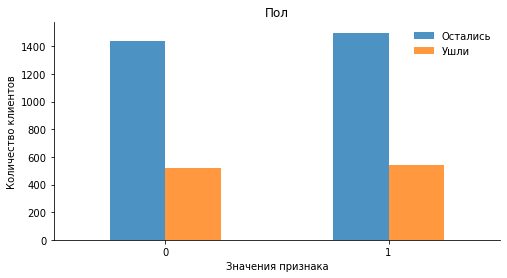

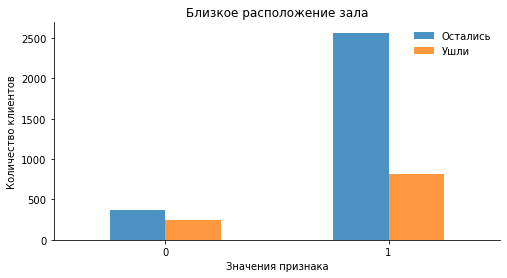

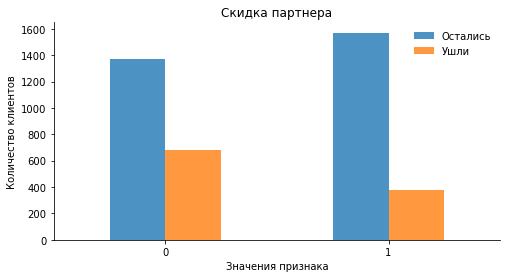

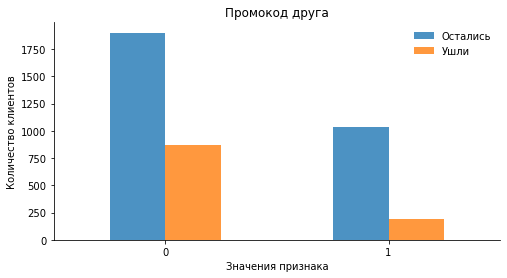

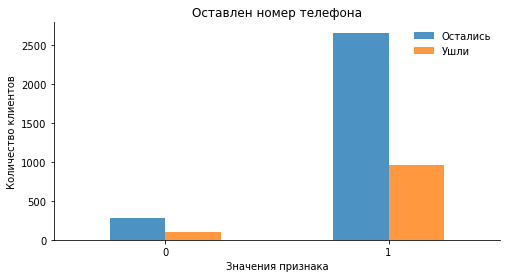

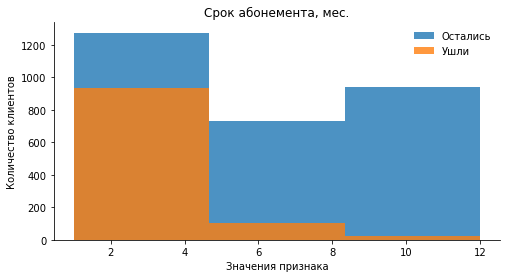

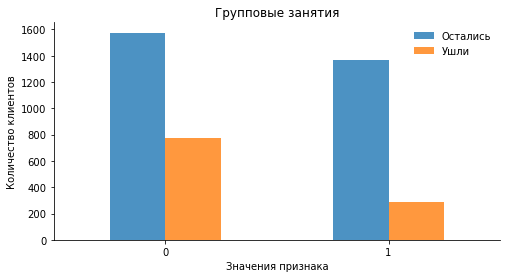

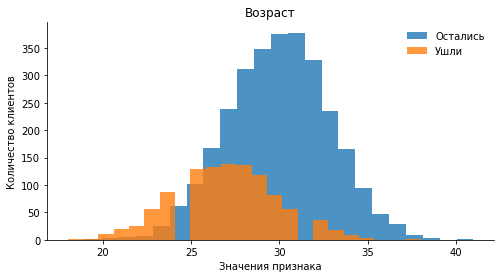

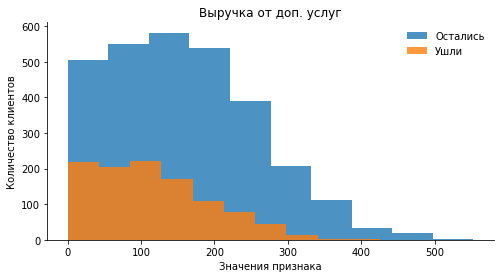

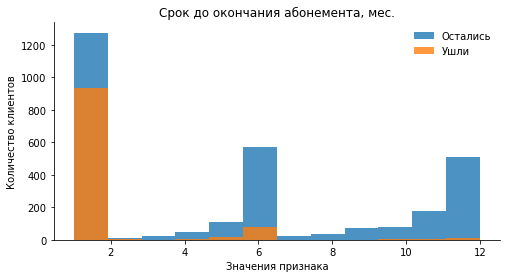

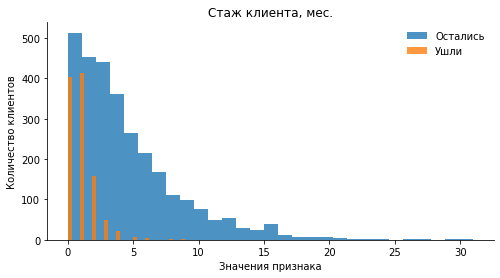

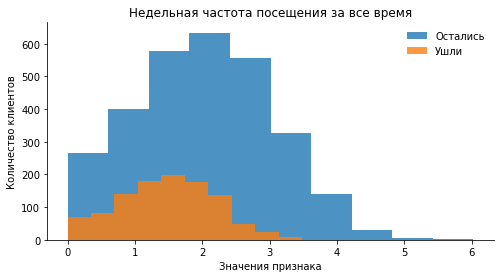

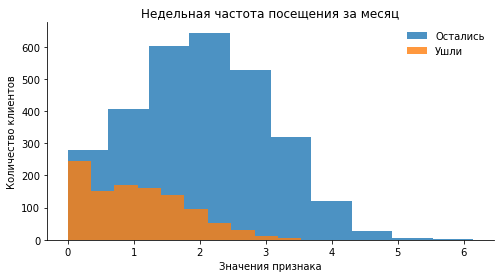

In [13]:
# столбчатые гистограммы и распределения признаков по факту оттока
for column in gym.drop(['churn'] , axis=1):
    if str(gym[column].dtypes)[:-2] == 'int':
        if gym[column].nunique() == 2:
            gym.groupby([column, 'churn'])['churn'].count().unstack().plot.bar(
                alpha = 0.8, 
                rot=0,
                figsize=(8, 4)
            )
        else: 
            gym.groupby('churn')[column].hist(
                bins=gym[column].nunique(),
                stacked=True,
                alpha = 0.8,
                figsize=(8, 4)
            )
    else:
        gym.groupby('churn')[column].hist(
            alpha = 0.8,
            figsize=(8, 4)
        )
        
    sns.despine()
    plt.grid(False)
    plt.ylabel('Количество клиентов')
    plt.xlabel('Значения признака')
        
    plt.legend(
        ['Остались', 'Ушли'],
        title='',
        loc=1,#9,
        frameon=False 
    )

    plt.title(column_dict[column])

    plt.show()

__Результаты анализа признаков при разбивке клиентов по факту оттока:__
- Основная доля уходящих клиентов приобретали месячные абонементы, судя по показателям lifetime (1 мес.) и contract_period (1,7 мес.). С длительностью абонемента от полугода клиент скорее останется
- В последний месяц перед уходом клиенты посещали зал в среднем раз в неделю, при норме лояльного клиента два раза в неделю.
- Близкое проживание или работа не сильно влияют на мотивацию к уходу.
- Скидка от партнера клуба была у трети ушедших, тогда как среди оставшихся клиентов таких половина.
- Промо-код от знакомого был у пятой части ушедших, тогда как среди оставшихся клиентов таких треть.
- Указание контактного телефона не влияет на мотивацию к уходу.
- Почти половина лояльных клиентов посещает групповые занятия, а среди ушедших таких чуть больше четверти.
- В среднем ушедшие клиенты более молоды, чем оставшиеся — 27 лет против 30 лет.
- Лояльные клиенты тратят на 50% больше ушедших: около 160 в месяц против 115.

### Матрица корреляций признаков

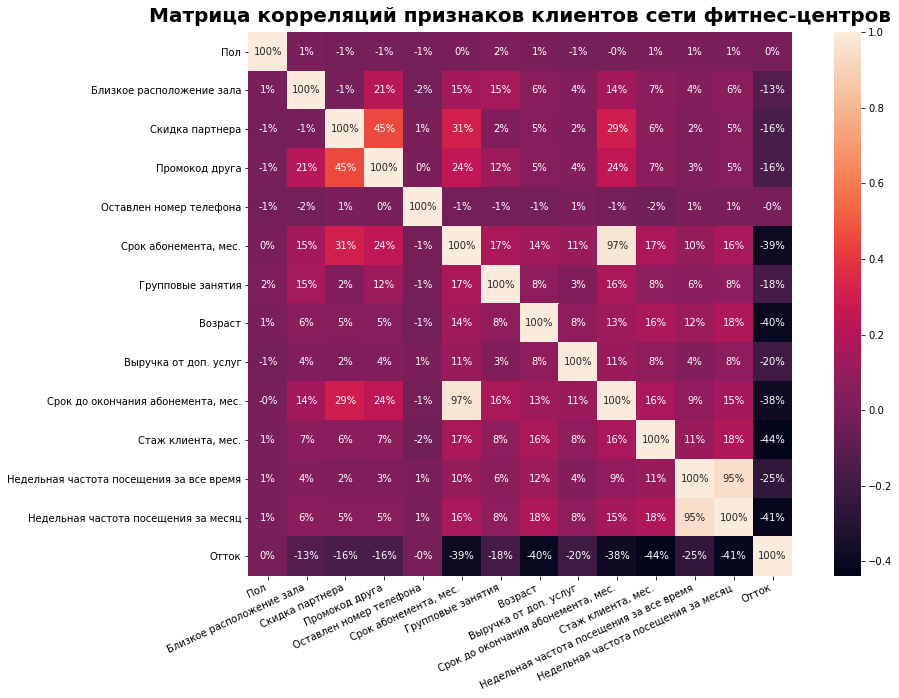

In [14]:
# корреляционная матрица
corr_m = gym.corr()

# heatmap корреляционной матрицы
plt.figure(figsize=(15, 10))
plt.title('Матрица корреляций признаков клиентов сети фитнес-центров', **title_font)
sns.heatmap(
    corr_m, 
    annot=True, 
    square = True, 
    fmt='.0%',
)

plt.gca().set_xticklabels(
    [column_dict.get(x) for x in gym.columns],
    rotation=25,
    ha='right'
)
plt.gca().set_yticklabels(
    [column_dict.get(x) for x in gym.columns],
)

plt.show()

Сильная корреляция наблюдается у признаков, который взаимосвязаны по своей сути:
- действия контракта: `month_to_end_contract` и `contract_period`,
- посещаемость: `avg_class_frequency_current_month` и `avg_class_frequency_total`.  

Остальные признаки слабо скоррелированы.

### Вывод по разделу

Основные признаки, наиболее сильно влияющие на отток, по результатам исследовательского анализа данных:
- __Длительность купленного абонемента.__ Основная доля уходящих клиентов приобретали месячные абонементы, судя по показателям lifetime (1 мес.) и contract_period (1,7 мес.). С длительностью абонемента от полугода клиент скорее останется.
- __Посещаемость.__ В последний месяц перед уходом клиенты посещали зал в среднем полтора раз в неделю, при норме лояльного клиента два раза в неделю. При приближении момента ухода показатель снижается до одного посещения в неделю.
- __Траты на доп. услуги фитнес-центра.__ Лояльные клиенты тратят на 50% больше ушедших: около 160 в месяц против 115.
- __Интерес к групповым занаятиям.__ Почти половина лояльных клиентов посещает групповые занятия, а среди ушедших таких чуть больше четверти. Вероятно это обусловлено условиями абонемента.
- __Возраст.__ Более молодые клиенты менее консервативны и готовы менять поставщика услуг.

## Прогноз оттока пользователей
<a id = "churn_forecast"></a>
[В оглавление](#index)

Прогноз оттока необходимо спрогнозировать путем __бинарной классификации__ пользователей. Целевой признак — факт оттока пользователя в следующем месяце.  
Для построения модели бинарной классификации большое количество признаком не является проблемой, как в регрессионой модели (проблема мультиколлинеарности). __Удаление признаков из датафрейма в данном случае не требуется.__

Порядок прогнозирования оттока пользователей:
- разделение данных на выборки для обучения и теста;
- подготовка моделей прогнозирования:
    - __обязательные__ по условию задачи:
        - логистическая регрессия,
        - random forest (случайные леса),
    - дополнительные:
        - дерево принятия решений,
        - градиентный бустинг.    
- выбор лучшей модели прогнозирования;
- финальный прогноз.



In [15]:
# разделение данных на признаки (матрица X) и целевую переменную (y)
X = gym.drop('churn', axis = 1) 
y = gym['churn']

# стандартизация данных
sc = StandardScaler()
X_st = sc.fit_transform(X)

# разделение модели на обучающую и валидационную выборку в пропорции 80/20%
X_train, X_test, y_train, y_test = train_test_split(X_st, y, test_size=0.2, random_state=0, stratify=y)

In [16]:
# параметр для синхронизации результатов от запуска кода в разное время
random_state = 0
# количество используемых деревьев решений
n_estimators = 100

In [17]:
# список моделей
models = [
    LogisticRegression(random_state = random_state),
    RandomForestClassifier(n_estimators = n_estimators, random_state = random_state),
    DecisionTreeClassifier(random_state = random_state),
    GradientBoostingClassifier(n_estimators = n_estimators, random_state = random_state)
]

In [18]:
# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print('Модель: {}'.format(str(m)))
    print('Accuracy: {:.0%}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: {:.0%}'.format(precision_score(y_test, y_pred)))
    print('Recall: {:.0%}'.format(recall_score(y_test, y_pred))) 
    print('F1: {:.0%}'.format(f1_score(y_test, y_pred)))

In [19]:
# цикл вывода метрик по списку моделей
for i in models:
    make_prediction(i, X_train, y_train, X_test, y_test)
    print()

Модель: LogisticRegression(random_state=0)
Accuracy: 94%
Precision: 90%
Recall: 85%
F1: 87%

Модель: RandomForestClassifier(random_state=0)
Accuracy: 92%
Precision: 88%
Recall: 83%
F1: 85%

Модель: DecisionTreeClassifier(random_state=0)
Accuracy: 89%
Precision: 78%
Recall: 80%
F1: 79%

Модель: GradientBoostingClassifier(random_state=0)
Accuracy: 94%
Precision: 92%
Recall: 84%
F1: 88%



Для прогноза оттока клиентов необходимо использовать __модель градиентного бустинга__ из-за лучших метрик.

In [20]:
# выбор алгоритма финальной модели
final_model = GradientBoostingClassifier(n_estimators = n_estimators, random_state = random_state)
# обучение финальной модели
final_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=0)

Составления списка клиентов для предотвращения их ухода.  
_Не совсем корректно использовать одни и те же данные для обучения модели и предсказания._  
_Данный блок подготовлен скорее для демонстрации полного pipeline._

In [21]:
clients_to_bring_over_back = gym.query('churn == 0').drop('churn', axis = 1)
df = sc.fit_transform(clients_to_bring_over_back).copy()

# бинарный прогноз ухода
clients_to_bring_over_back['churn_pred'] = final_model.predict(df)
# вероятность ухода
clients_to_bring_over_back['churn_prob'] = final_model.predict_proba(df)[:,1]

In [22]:
# перечень клиентов, наиболее близких к уходу
clients_to_bring_over_back[['churn_pred', 'churn_prob']].query('churn_pred == 1'). \
    sort_values('churn_prob', ascending=False)

,churn_pred,churn_prob
2234,1,0.99
3385,1,0.98
1886,1,0.98
2768,1,0.97
8,1,0.97
...,...,...
2081,1,0.51
2803,1,0.50
612,1,0.50
1610,1,0.50


### Вывод по разделу

- Модель градиентного бустинга показала лучшие параметры прогнозирования.
- Подготовлен перечень клиентов для первоочередной проработки предотвращения ухода.

## Кластеризация пользователей
<a id = "clustering"></a>
[В оглавление](#index)

Порядок кластеризации пользователей:
- стандартизация данных,
- построение матрицы расстояний,
- построение дендрограммы,
- обучение модели кластеризации,
- прогнозирование кластеров клиентов,
- построение распределения признаков для кластеров,
- анализ средних значений,
- расчет доли оттока по кластеру.

In [23]:
# исключение столбца с признаком оттока 
gym_st = gym.drop('churn', axis=1)

# стандартизация данных
x_sc = sc.fit_transform(gym_st)

# построение матрицы расстояний 
linked = linkage(x_sc, method = 'ward')

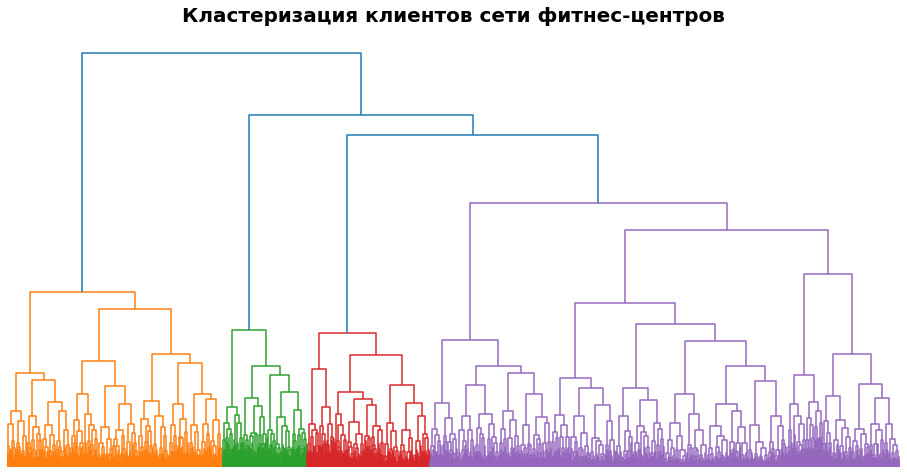

In [24]:
# построение дендрограммы
plt.figure(figsize=(16, 8))  
dendrogram(linked, orientation='top', no_labels=True)
sns.despine(
    left=True, 
    bottom=True
)
plt.gca().set_yticks([])
plt.title('Кластеризация клиентов сети фитнес-центров', **title_font)
plt.show()

Оптимальное число кластеров — 4, согласно результатам визуального анализа дендрограммы.  
__Согласно условию задания, далее используется число кластеров — 5.__

In [25]:
n_clusters = 5

In [26]:
# обучение модели кластеризации
km = KMeans(n_clusters = n_clusters)

# прогноз кластеров 
labels = km.fit_predict(x_sc)

# сохранение меток кластера в датафрейм
gym['cluster_churn'] = labels

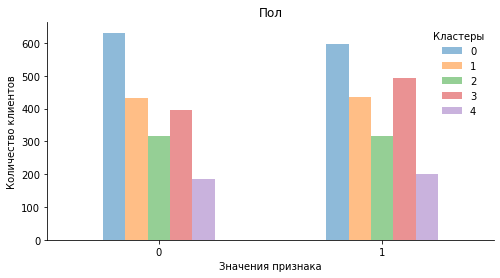

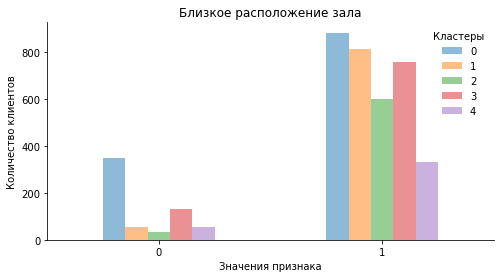

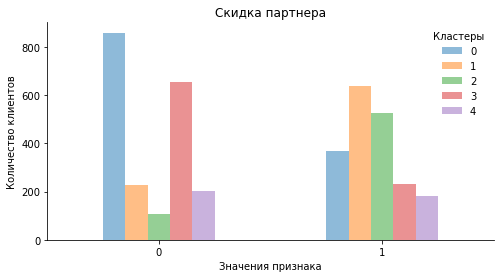

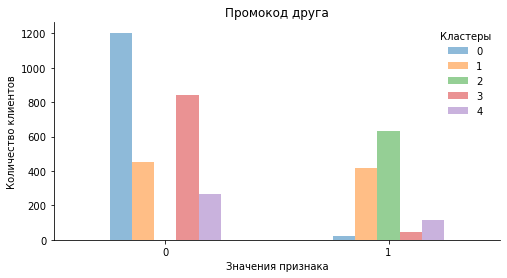

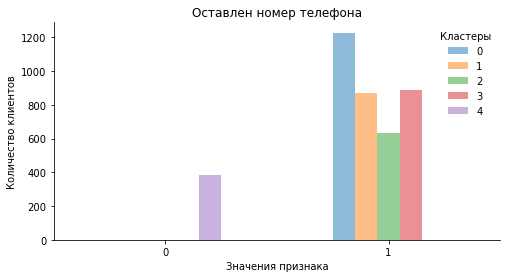

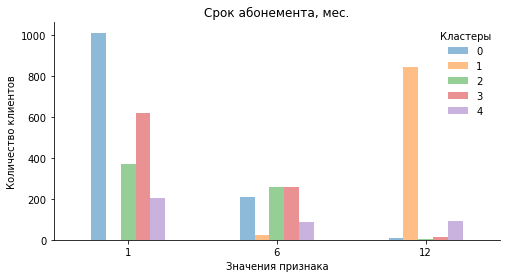

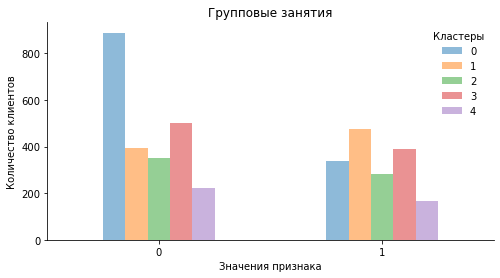

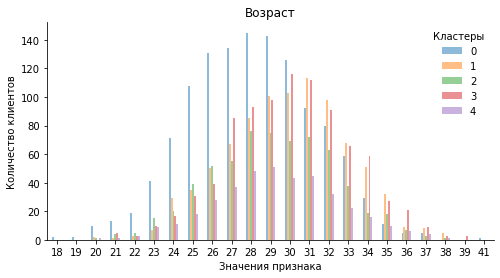

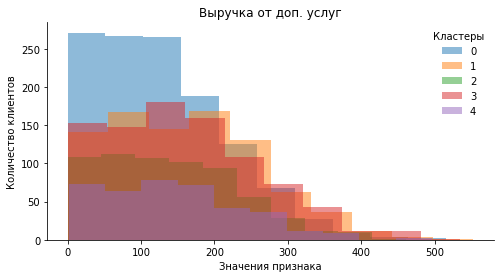

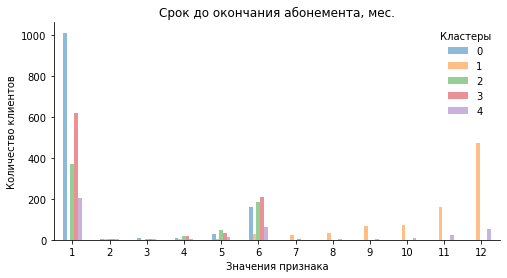

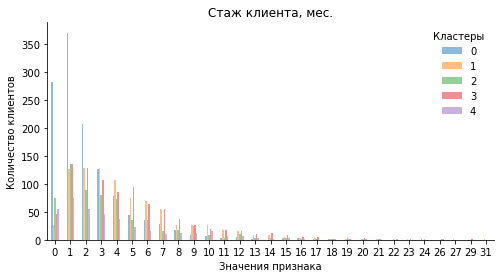

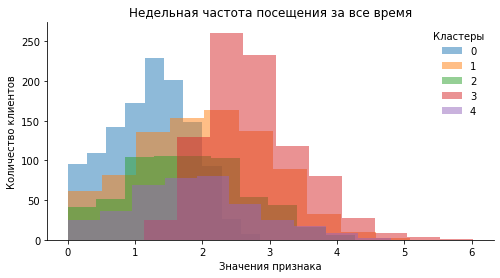

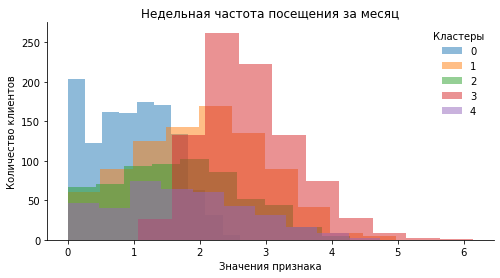

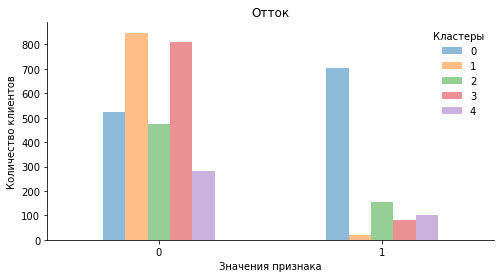

In [27]:
# распределение признаков по кластерам
for column in gym.drop(['cluster_churn'] , axis=1):
    if str(gym[column].dtypes)[:-2] == 'int':
        if gym[column].nunique() == 2:
            gym.groupby([column, 'cluster_churn'])['cluster_churn'].count().unstack().plot.bar(
                alpha = 0.5, 
                rot=0,
                figsize=(8, 4),
                legend=True
            )
        else:
            gym.groupby([column, 'cluster_churn'])['cluster_churn'].count().unstack().plot.bar(
                alpha = 0.5, 
                rot=0,
                figsize=(8, 4),
                legend=True
            )
            
    else:
        try:
            gym.groupby('cluster_churn')[column].hist(alpha = 0.5, figsize=(8, 4))
        except:
            continue
        
        
    sns.despine()
    plt.grid(False)
    plt.ylabel('Количество клиентов')
    plt.xlabel('Значения признака')
        
    plt.legend(
        title='Кластеры',
        labels=range(n_clusters),
        loc=1,
        frameon=False 
    )

    plt.title(column_dict[column])

    plt.show()

In [28]:
# средние значения признаков в разбивке по кластерам
clusters_mean_features = gym.groupby(['cluster_churn']).mean().transpose()
clusters_mean_features = clusters_mean_features.sort_values(by = 'churn', ascending=False, axis = 1) 
clusters_mean_features.index = clusters_mean_features.index.map(column_dict.get)
clusters_mean_features.columns.name = 'Кластеры'
clusters_mean_features

Кластеры,0,4,2,3,1
Пол,0.49,0.52,0.50,0.55,0.50
Близкое расположение зала,0.72,0.86,0.95,0.85,0.94
Скидка партнера,0.30,0.47,0.83,0.26,0.74
Промокод друга,0.02,0.31,1.00,0.05,0.48
Оставлен номер телефона,1.00,0.00,1.00,1.00,1.00
"Срок абонемента, мес.",1.91,4.78,3.08,2.60,11.85
Групповые занятия,0.28,0.43,0.45,0.44,0.55
Возраст,28.08,29.30,29.12,30.01,29.89
Выручка от доп. услуг,129.50,144.21,141.84,159.79,163.42
"Срок до окончания абонемента, мес.",1.82,4.47,2.88,2.42,10.80


Типичные характеристики клиентов наименее лояльного кластера в сравнении с другими кластерами:
- самый короткий срок абонемента, купленного изначально. Можно заключить, что в кластер попали клиенты, которые решили попробовать услуги зала прежде чем купить долгосрочный абонемент.
- наибольшая доля клиентов, живущих или работающих вдали от зала — 25%;
- наименьшая заинтересованность в групповых занятиях и дополнительных услугах фитнес-центра;
- наименьший средний возраст среди кластеров — 28 лет.

## Выводы и рекомендации
<a id = "conclusion"></a>
[В оглавление](#index)

__Типичные портреты пользователей:__
- Наиболее лояльные клиенты (номер кластера зависит от запуска кода):
    - около 25% клиентской базы;
    - почти все живут или работают около фитнес-центров;
    - пришли от партнера или по рекомендации от друзей;
    - в основном, годовые абоненты;
    - около половины ходят на групповые занятия;
    - наибольшая средняя выручка по доп. услугам.
- Группа среднего риска по оттоку (номера кластеров зависят от запуска кода):
    - около трети клиентской базы;
    - абонементы по полгода;
    - активно посещают зал и занятия на старте; 
- Целевая группа для сокращения оттока (номер кластера зависит от запуска кода):
    - больше трети клиентской базы;
    - самый короткий срок абонемента, купленного изначально. Можно заключить, что в кластер попали клиенты, которые решили попробовать услуги зала прежде чем купить долгосрочный абонемент.
    - наибольшая доля клиентов, живущих или работающих вдали от зала — 25%;
    - наименьшая заинтересованность в групповых занятиях и дополнительных услугах фитнес-центра;
    - наименьший средний возраст среди кластеров — 28 лет.  
    
__Основные признаки, наиболее сильно влияющие на отток:__
- __Длительность купленного абонемента.__ Основная доля уходящих клиентов приобретали месячные абонементы, судя по показателям lifetime (1 мес.) и contract_period (1,7 мес.). С длительностью абонемента от полугода клиент скорее останется.
- __Посещаемость.__ В последний месяц перед уходом клиенты посещали зал в среднем полтора раз в неделю, при норме лояльного клиента два раза в неделю. При приближении момента ухода показатель снижается до одного посещения в неделю.
- __Траты на доп. услуги фитнес-центра.__ Лояльные клиенты тратят на 50% больше ушедших: около 160 в месяц против 115.
- __Интерес к групповым занаятиям.__ Почти половина лояльных клиентов посещает групповые занятия, а среди ушедших таких чуть больше четверти. Вероятно это обусловлено условиями абонемента.
- __Возраст.__ Более молодые клиенты менее консервативны и готовы менять поставщика услуг.

__Меры по снижению оттока:__
- Сконцентрироваться на конверсии абонементов клиентов из месячных в среднесрочные и долгие. Годовой абонемент ожидаемо мотивирует отхаживать занятия, клиенты менее склонны к оттоку и готовы оплачивать доп. услуги. Вероятно, стоит запустить спец. предложения на абонементы длительностью от года.
- Таргетировать рекламу на клиентов, живущих или работающих близко от фитнес-центра. Такие клиенты наиболее вероятно будут посещать фитнес-центр и поднимут LTV.
- Запустить акции или бесплатные пробные занятия в кластерах среднего риска для повышения средней выручки, где клиенты уже купили среднесрочные абонементы, но пока не начали тратить на доп. услуги.